# SNN

--------------------------
## Personal
#### Things to Do:
- (DONE) L2 normalisation gives slower training so that line has been commented out.Need to figure out why that's happening and if it is normal
- (DONE) Implement modified softmax
- (DONE) Combine DenseNet and Modified Softmax
- Figure out class weights and incorporate that
- check if alpha needs a relu (only with actual embeddings)
- Batching the training
- Logging information nicely
--------------------------

## Resources and Information

Additive margin loss: https://arxiv.org/pdf/1801.05599.pdf
<br>Large margin softmax: https://arxiv.org/pdf/1612.02295.pdf https://github.com/auroua/L_Softmax_TensorFlow/blob/master/nets/l_softmax.py

--------------------------

## Code
--------------------------

In [31]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
from keras.datasets import mnist
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

### MNIST Data

In [6]:
(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = mnist.load_data()
x_train_mnist = x_train_mnist.reshape(x_train_mnist.shape[0], 784)
x_test_mnist = x_test_mnist.reshape(x_test_mnist.shape[0], 784)
x_train_mnist = x_train_mnist.astype('float32')
x_test_mnist = x_test_mnist.astype('float32')
x_train_mnist /= 255
x_test_mnist /= 255

data_size = 5000

X_mnist = x_train_mnist[:data_size]
y_mnist = y_train_mnist[:data_size]

y_onehot_mnist = np.zeros([data_size, 10])
y_onehot_test_mnist = np.zeros([len(y_test_mnist), 10])

for a in range(data_size):
    y_onehot_mnist[a][y_mnist[a]] = 1
for a in range(len(y_test_mnist)):
    y_onehot_test_mnist[a][y_test_mnist[a]] = 1

### Network Parameters

In [88]:
input_size = 28*28
n_layers = 10
n_classes = 10
n_units = 30
batch_size = 50
epochs = 50
learning_rate = 0.05

### Accuracy Function

In [89]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))/ predictions.shape[0])

### Dense Network with Softmax on Onehot Encoding

In [90]:
tf.reset_default_graph()

inputs = tf.placeholder(tf.float32, [None, input_size])
original_input = inputs
labels = tf.placeholder(tf.float32, [None, n_classes])

for a in range(n_layers):
    layer = tf.layers.dense(inputs, n_units, 'selu', name='layer'+str(a))
    inputs = tf.concat([inputs, layer], 1, name='concatenation'+str(a))

logits = tf.layers.dense(inputs, n_classes, None, name='output')
logits = tf.math.l2_normalize(logits, axis=1)

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))

predictions = tf.nn.softmax(logits)

optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

### Running the Network

In [91]:
with tf.Session() as session:
    tf.initialize_all_variables().run()
    print("Initialized")

    for a in range(epochs):
        _, l, p = session.run([optimizer, loss, predictions], 
                              feed_dict={original_input:X_mnist, labels:y_onehot_mnist})

        if a%50==0 or 1:
            print("Epoch:", a+1, "\tLoss:", l, "\tAccuracy:", accuracy(p, y_onehot_mnist))

    test_p = session.run(predictions, feed_dict={original_input:x_test_mnist, labels:y_onehot_test_mnist})

    print("Test Accuracy: ", accuracy(test_p, y_onehot_test_mnist))

    
    tf.summary.FileWriter('./logs', session.graph)

Initialized
Epoch: 1 	Loss: 2.3991852 	Accuracy: 7.22
Epoch: 2 	Loss: 1.9697156 	Accuracy: 46.56
Epoch: 3 	Loss: 2.2053034 	Accuracy: 26.2
Epoch: 4 	Loss: 2.1088948 	Accuracy: 33.92
Epoch: 5 	Loss: 2.1498044 	Accuracy: 17.34
Epoch: 6 	Loss: 1.9769281 	Accuracy: 41.06
Epoch: 7 	Loss: 1.9603381 	Accuracy: 40.24
Epoch: 8 	Loss: 1.8726305 	Accuracy: 58.4
Epoch: 9 	Loss: 1.849096 	Accuracy: 63.82
Epoch: 10 	Loss: 1.8369582 	Accuracy: 58.68
Epoch: 11 	Loss: 1.7982334 	Accuracy: 63.4
Epoch: 12 	Loss: 1.7612938 	Accuracy: 69.42
Epoch: 13 	Loss: 1.7339334 	Accuracy: 71.58
Epoch: 14 	Loss: 1.7136658 	Accuracy: 71.48
Epoch: 15 	Loss: 1.7003529 	Accuracy: 72.0
Epoch: 16 	Loss: 1.6790887 	Accuracy: 75.78
Epoch: 17 	Loss: 1.6647344 	Accuracy: 75.64
Epoch: 18 	Loss: 1.651609 	Accuracy: 77.26
Epoch: 19 	Loss: 1.6402272 	Accuracy: 77.88
Epoch: 20 	Loss: 1.6242397 	Accuracy: 79.28
Epoch: 21 	Loss: 1.6138338 	Accuracy: 80.88
Epoch: 22 	Loss: 1.6025642 	Accuracy: 84.2
Epoch: 23 	Loss: 1.5948198 	Accuracy:

### Modified Softmax Function

In [79]:
embedding_length = 12
number_of_samples = 22
number_of_classes = 27

tf.reset_default_graph()

labels = tf.placeholder(tf.int32, [None], name='labels')

embeddings = tf.placeholder(tf.float32, [None, embedding_length])
norm_embeddings = tf.nn.l2_normalize(embeddings, axis=1, name='embeddings')

class_weights = tf.constant(normalize(np.random.rand(embedding_length, number_of_classes)), dtype=tf.float32,
                           name='class_weights')

margin = tf.placeholder(tf.float32, name='margin')

alpha_initial = tf.get_variable(dtype=tf.float32, initializer=tf.constant(np.random.rand(1), dtype='float32'), name='alpha')
alpha = tf.nn.relu(alpha_initial)

cosines = tf.matmul(norm_embeddings, class_weights, name='cosines')
onehot_label = tf.one_hot(labels, number_of_classes, name='labels_onehot')
m_onehot = tf.math.multiply(margin, onehot_label, name='mxonehot')
margin_cosine = tf.subtract(cosines, m_onehot, name='cosine-m')
alpha_margin_cosine = tf.math.exp(tf.math.multiply(alpha, margin_cosine), name='alphaxc-m')
amc_numerator = tf.reduce_sum(tf.multiply(alpha_margin_cosine, onehot_label), axis=1, name='amc_positive')
amc_denominator = tf.reduce_sum(alpha_margin_cosine, axis=1, name='amc_total')
amc_fraction = tf.divide(amc_numerator, amc_denominator, name='amc_fraction')
log_amcf = -tf.log(amc_fraction, name='log_amc')
loss = tf.reduce_mean(log_amcf, name='loss')

m = 0
m_change = 0.00002
m_max = 25

optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

with tf.Session() as session:
    feed_dict={embeddings:np.random.rand(number_of_samples, embedding_length),
                                     labels: np.random.randint(0, number_of_classes, number_of_samples),
                                      margin: m}
    alpha_initial.initializer.run()
    
    for a in range(10):
        l, o, a = session.run([loss, optimizer, alpha], feed_dict=feed_dict)
        print(l, a)
        feed_dict[margin] = min(feed_dict[margin]+m_change, m_max)
    tf.summary.FileWriter('./logs', session.graph)

3.3053637 [0.30579776]
3.3053641 [0.30563483]
3.3053648 [0.3054718]
3.3053656 [0.3053087]
3.3053658 [0.3051455]
3.3053665 [0.30498222]
3.3053672 [0.30481884]
3.3053672 [0.30465537]
3.305368 [0.30449182]
3.3053682 [0.30432817]


### DenseNet with Modified Softmax Function

In [92]:
input_size = 28*28
n_layers = 10
n_classes = 10
n_units = 12
batch_size = 50
epochs = 50
learning_rate = 0.005

embedding_length = 12
number_of_samples = 300

In [93]:
tf.reset_default_graph()

inputs = tf.placeholder(tf.float32, [None, input_size], name='gene_expression')
original_input = inputs
labels = tf.placeholder(tf.int32, [None], name='labels')

for a in range(n_layers):
    layer = tf.layers.dense(inputs, n_units, 'selu', name='layer'+str(a))
    inputs = tf.concat([inputs, layer], 1, name='concatenation'+str(a))

embeddings = tf.layers.dense(inputs, embedding_length, None, name='embedding')
norm_embeddings = tf.nn.l2_normalize(embeddings, axis=1, name='norm_embeddings')

class_weights = tf.constant(normalize(np.random.rand(embedding_length, n_classes)), dtype=tf.float32,
                           name='class_weights')

margin = tf.placeholder(tf.float32, name='margin')

alpha_initial = tf.get_variable(dtype=tf.float32, initializer=tf.constant(np.random.rand(1), dtype='float32'), 
                                name='alpha')
alpha = tf.nn.relu(alpha_initial)

cosines = tf.matmul(norm_embeddings, class_weights, name='cosines')
onehot_label = tf.one_hot(labels, n_classes, name='labels_onehot')
m_onehot = tf.math.multiply(margin, onehot_label, name='mxonehot')
margin_cosine = tf.subtract(cosines, m_onehot, name='cosine-m')
alpha_margin_cosine = tf.math.exp(tf.math.multiply(alpha, margin_cosine), name='alphaxc-m')
amc_numerator = tf.reduce_sum(tf.multiply(alpha_margin_cosine, onehot_label), axis=1, name='amc_positive')
amc_denominator = tf.reduce_sum(alpha_margin_cosine, axis=1, name='amc_total')
amc_fraction = tf.divide(amc_numerator, amc_denominator, name='amc_fraction')
log_amcf = -tf.log(amc_fraction, name='log_amc')
loss = tf.reduce_mean(log_amcf, name='loss')

m = 0
m_change = 0.00002
m_max = 25

optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

In [98]:
with tf.Session() as session:
    feed_dict={original_input:np.random.rand(number_of_samples, input_size),
                                     labels: np.random.randint(0, n_classes, number_of_samples),
                                      margin: m}
    
    feed_dict={original_input:X_mnist, labels: y_mnist, margin: m}
    
    
    alpha_initial.initializer.run()
    tf.initialize_all_variables().run()
    print("Initialized")
    losses = []
    for a in range(1000):
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        if a%50==0:
            print("Epoch:", a+1, "\tLoss:", l)
        losses.append(l)
        feed_dict[margin] = min(feed_dict[margin]+m_change, m_max)
    tf.summary.FileWriter('./logs', session.graph)

Initialized
Epoch: 1 	Loss: 2.3018057
Epoch: 51 	Loss: 2.1486962
Epoch: 101 	Loss: 2.0130262
Epoch: 151 	Loss: 1.8926766
Epoch: 201 	Loss: 1.7824774
Epoch: 251 	Loss: 1.6803116
Epoch: 301 	Loss: 1.6004846
Epoch: 351 	Loss: 1.5030854
Epoch: 401 	Loss: 1.4158542
Epoch: 451 	Loss: 1.3359962
Epoch: 501 	Loss: 1.2616202
Epoch: 551 	Loss: 1.1921333
Epoch: 601 	Loss: 1.1273557
Epoch: 651 	Loss: 1.0669711
Epoch: 701 	Loss: 1.0107015
Epoch: 751 	Loss: 0.95831007
Epoch: 801 	Loss: 0.90945154
Epoch: 851 	Loss: 0.8639754
Epoch: 901 	Loss: 0.82161486
Epoch: 951 	Loss: 0.7821442


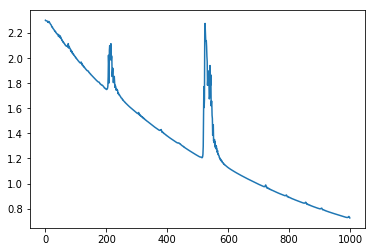

In [97]:
plt.plot(np.arange(len(losses)), losses)
plt.show()